# Entrenament dels models amb les mamografies retallades (patches)

### Input: arrays de numpy, disponibles a https://zenodo.org/records/11528282

### Output: Millors models obtinguts per cada model en format .h5

**En aquest apartat entrenarem els models a partir dels arrays de numpy exportats a colab per aprofitar la GPU. Les entrades al model són els arrays de imatges preprocessades i les etiquetes corresponents.**

- En primer lloc visualitzarem els resultats per comprovar que la importació sigui correcta.

- Crearem uns tensors de tensorflow amb un número de batch de 32

- Crearem una classe per generar models i evaluar-los.

- En primer lloc entrenarem un model des de zero, per tal de tenir una referència

- Entrenarem 3 models mitjançant transfer learning: Efficientnentb2, VGG19 i InceptionV3

- Aplicar fine-tuning descongelant els dos últims blocs (progressivament)

In [2]:
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, AveragePooling2D,
    MaxPooling2D, UpSampling2D, Rescaling, Resizing,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, Lambda, Activation)
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from keras.optimizers import (Adam, RMSprop)
from keras import Sequential, Model
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import random
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

zip_file_path = '/content/drive/MyDrive/patches_224.zip'

# Ruta de extracción
extract_path = '/content/'

# Descomprimir el archivo zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Arxiu descomprimit a:", extract_path)

Arxiu descomprimit a: /content/


In [5]:
# Importem Tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necessitarem GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

#Keras version is 3.0.5
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.15.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  2.15.0


### Creem conjunt de dades anotades de mamografies amb contrast


In [6]:
test_images = np.load('/content/test_images.npy')
test_labels = np.load('/content/test_labels.npy')
val_images = np.load('/content/val_images.npy')
val_labels = np.load('/content/val_labels.npy')
train_images = np.load('/content/train_images.npy')
train_labels = np.load('/content/train_labels.npy')

In [7]:
train_images.shape

(1646, 224, 224, 3)

## Comprovem que l'importació s'hagi realitzat correctament

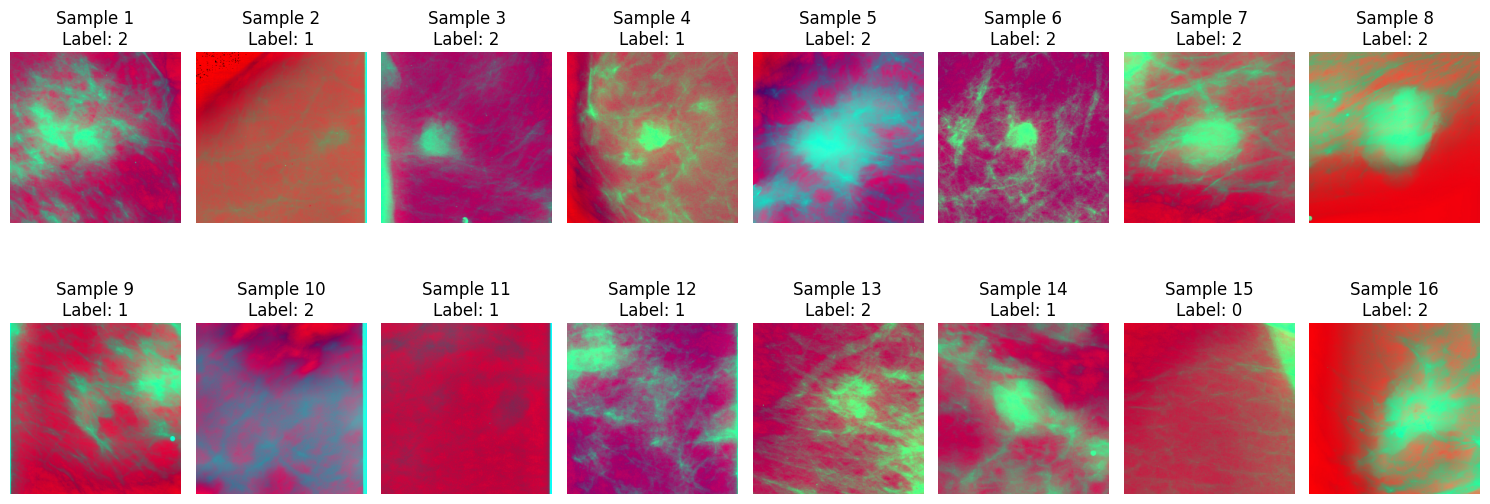

In [8]:
def check_import(test_images, test_labels, num_ex):
    """
    Mostra una selecció d'imatges amb les seves etiquetes corresponents per comprovar el preprocessat.

    Args:
    - test_images (array): Array que conté les imatges a visualitzar.
    - test_labels (array): Array que conté les etiquetes corresponents a les imatges.
    - num_ex (int): Nombre d'imatges a visualitzar.

    Returns:
    - No retorna cap valor, només mostra les imatges i les seves etiquetes associades.
    """

    num_rows = (num_ex + 7) // 8
    fig, axes = plt.subplots(num_rows, 8, figsize=(15, num_rows * 3))

    for i in range(num_ex):
        row = i // 8
        col = i % 8
        axes[row, col].imshow(test_images[i])
        axes[row, col].set_title(f"Sample {i+1}\nLabel: {test_labels[i]}")
        axes[row, col].axis('off')

    for i in range(num_ex, num_rows * 8):
        row = i // 8
        col = i % 8
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

check_import(test_images, test_labels, 16)

### UTILS


In [9]:
def plot_metrics(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, test_ds):
    """
    Avalua un model utilitzant un conjunt de dades de prova i retorna les prediccions i les imatges.

    Args:
    - model: Model a avaluar.
    - test_ds: Conjunt de dades de prova.

    Returns:
    - y_true: Etiquetes reals del conjunt de dades de prova.
    - y_pred: Prediccions del model.
    - imatges_array: Array que conté les imatges utilitzades per a la predicció.
    """
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return y_true, y_pred


def plot_sample_images(train_ds, num_samples=9):
    """
    Mostra una mostra d'imatges amb les seves etiquetes corresponents.

    Args:
    - train_ds (tf.data.Dataset): Dataset d'entrenament que conté les imatges i les seves etiquetes.
    - num_samples (int): Nombre d'imatges a mostrar.

    Returns:
    - No retorna cap valor, només mostra les imatges i les seves etiquetes associades.
    """
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(min(num_samples, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(str(labels[i].numpy()))
            plt.axis("off")
            height, width, channels = images[i].shape
            pixel_range = (np.min(images[i]), np.max(images[i]))


def replicate_augmented_images(train_ds, model_augmentation, num_replications=4):
    """
    Reprodueix una imatge aleatòria del conjunt de dades d'entrenament múltiples vegades amb augmentació.

    Args:
    - train_ds (tf.data.Dataset): Dataset d'entrenament que conté les imatges.
    - model_augmentation (tf.keras.Sequential): Model d'augmentació que s'aplicarà a la imatge.
    - num_replications (int): Nombre de vegades que es vol replicar la imatge amb augmentació.

    Returns:
    - No retorna cap valor, només mostra les imatges amb augmentació.
    """
    for images, _ in train_ds.take(1):
        sample_image = images[0]

    augmented_images = [model_augmentation(tf.expand_dims(sample_image, 0)) for _ in range(num_replications)]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, num_replications + 1, 1)
    plt.title('Imatge original')
    plt.imshow(sample_image.numpy().astype("uint8"))
    plt.axis("off")

    for i, augmented_image in enumerate(augmented_images):
        plt.subplot(1, num_replications + 1, i + 2)
        plt.title(f'Imatge amb augmentació {i+1}')
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")

    plt.show()


## Creem els tensors de tensorflow a partir dels arrays

In [10]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

## Augment de dades
Tot i que després ho utilitzarem dins del ModelGenerator, comprovem quines modificacions d'augmentació són acceptables

In [11]:
model_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomFlip("vertical"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1)
])

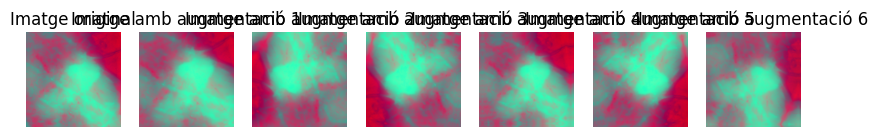

In [12]:
replicate_augmented_images(train_ds, model_augmentation, num_replications=6)

# Custom Model

**En aquest primer punt crearem una classe per construir i evaluar els models creats. Crearem una estructura simple amb una primera capa de Flatten/ Globalaveragepooling2D, seguida de x capes ocultes i una capa de dropout per cada una. Per acabar, una capa de sortida amb 3 neurones**

In [18]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19
from tensorflow.keras.applications.imagenet_utils import preprocess_input as preprocess_input_default

class CustomModel:
    def __init__(self, input_shape = (224,224,3), train_data = train_ds, val_data = val_ds, test_data = test_ds, pretrained_model=None, hidden_layers=None, dropout=None, pooling='flatten', weights='imagenet', num_outputs=3, model_augmentation=True):
        """
        Inicialitza una instància de la classe CustomModel per generar un model de xarxa neuronal convolucional (CNN) amb opcions per pre-entrenar i personalitzar les capes ocultes.

        Args:
        - input_shape (tuple): Dimensions de la imatge d'entrada (ex: (224, 224, 3)).
        - pretrained_model (str or None): Model pre-entrenat a utilitzar (opcions: 'inception', 'efficientnetb2', 'vgg19' o None per cap capa pre-entrenada).
        - hidden_layers (list or None): Llista de dimensions per les capes ocultes (ex: [126, 64, 32]) o None per cap capa oculta.
        - dropout (list or None): Llista de valors de dropout per a cada capa oculta o None per cap dropout.
        - pooling (str): Tipus de capa de pooling ('flatten' o 'globalaverage').
        - weights (str): Pesos inicials del model ('imagenet' o None).
        - num_outputs (int): Nombre de neurones a la capa de sortida.
        - trainable (bool): Indica si es permet re-entrenar les capes (True) o no (False).
        - trainable_layers (list or None): Llista de noms de les capes a re-entrenar o None per re-entrenar totes les capes.
        - model_augmentation (bool): Indica si es vol utilitzar data augmentació (True) o no (False).
        """
        self.input_shape = input_shape
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.pretrained_model = pretrained_model
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.pooling = pooling
        self.weights = weights
        self.num_outputs = num_outputs
        self.model_augmentation = model_augmentation

        self.pretrained_model_options = {
            'inception': tf.keras.applications.InceptionV3,
            'efficientnetb2': tf.keras.applications.EfficientNetB2,
            'vgg19': tf.keras.applications.VGG19,
            'none': None
        }

        self.pooling_options = {
            'flatten': Flatten,
            'globalaverage': GlobalAveragePooling2D
        }

    def generate_model(cls):
      # Selecció del model pre-entrenat
      base_model_class = cls.pretrained_model_options.get(cls.pretrained_model)
      base_model = None
      preprocess_input = preprocess_input_default

      if base_model_class:
          base_model = base_model_class(input_shape=cls.input_shape, include_top=False, weights=cls.weights)
          for layer in base_model.layers:
              layer.trainable = False
          if cls.pretrained_model == 'inception':
              preprocess_input = tf.keras.applications.inception_v3.preprocess_input
          elif cls.pretrained_model == 'efficientnetb2':
              preprocess_input = tf.keras.applications.efficientnet.preprocess_input
          elif cls.pretrained_model == 'vgg19':
              preprocess_input = tf.keras.applications.vgg19.preprocess_input

      # Construcció del model base
      scratch_model = [Conv2D(16, (3, 3), activation='relu', input_shape=cls.input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),]

      # Selecció de la capa de pooling
      pool_layer_class = cls.pooling_options.get(cls.pooling)
      pool_layer = None
      if pool_layer_class:
          pool_layer = pool_layer_class()

      # Construcció de les capes ocultes
      hidden_layers_list = []
      if cls.hidden_layers:
          hidden_layers_list.append(pool_layer)
          for units, drop_rate in zip(cls.hidden_layers, cls.dropout):
              hidden_layers_list.append(Dense(units, activation='relu'))
              if drop_rate:
                  hidden_layers_list.append(Dropout(drop_rate))
      else:
          hidden_layers_list = [pool_layer]

      # Construcció del model complet
      if base_model:
          if cls.model_augmentation:
              model_augmentation = tf.keras.Sequential([
                  RandomFlip("horizontal"),
                  RandomFlip("vertical"),
                  RandomContrast(0.1),
                  RandomRotation(0.1),
                  RandomZoom(0.1)
              ])
              model = Sequential([model_augmentation] + [Lambda(preprocess_input)] + [base_model] + hidden_layers_list + [Dense(cls.num_outputs, activation='softmax')])
          else:
              model = Sequential([Lambda(preprocess_input)] + [base_model] + hidden_layers_list + [Dense(cls.num_outputs, activation='softmax')])
      else:
          if cls.model_augmentation:
              model_augmentation = tf.keras.Sequential([
                  RandomFlip("horizontal"),
                  RandomFlip("vertical"),
                  RandomContrast(0.1),
                  RandomRotation(0.1),
                  RandomZoom(0.1)
              ])
              model = Sequential([model_augmentation] + [Lambda(preprocess_input)] + scratch_model +  hidden_layers_list + [Dense(cls.num_outputs, activation='softmax')])
          else:
              model = Sequential([Lambda(preprocess_input)] + scratch_model + hidden_layers_list + [Dense(cls.num_outputs, activation='softmax')])

      model.build((None, *cls.input_shape))

      return model

    def show_layers(self, model):
        for i, layer in enumerate(model.layers):
            print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")


    def train(self, model, optimizer = Adam(learning_rate=1e-3), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], epochs = 50, callbacks=None):

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        history = model.fit(self.train_data, epochs=epochs, validation_data=self.val_data, callbacks=callbacks)
        return history

    def full_report(self, model, history):

        plot_metrics(history)

        y_true, y_pred = evaluate_model(model, self.test_data)

        plot_confusion_matrix(y_true, y_pred, ('Normal', 'Benign', 'Malignant'))

        print(classification_report(y_true, y_pred))

        loss, accuracy = model.evaluate(self.test_data)

        print(f'Pèrdua en el conjunt de dades de test: {loss}')
        print(f'Precisió en el conjunt de dades de test: {accuracy}')

    def freeze_layers(self, model_initial, num_layers_to_freeze):
        for layer in model_initial.layers[2].layers[:num_layers_to_freeze]:
            layer.trainable = False
        for layer in model_initial.layers[2].layers[num_layers_to_freeze:]:
            layer.trainable = True
        return model_initial

results_path = '/content/drive/My Drive'


# 0. Model from scratch

## 0.1 Creem el model i l'entrenem

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                 

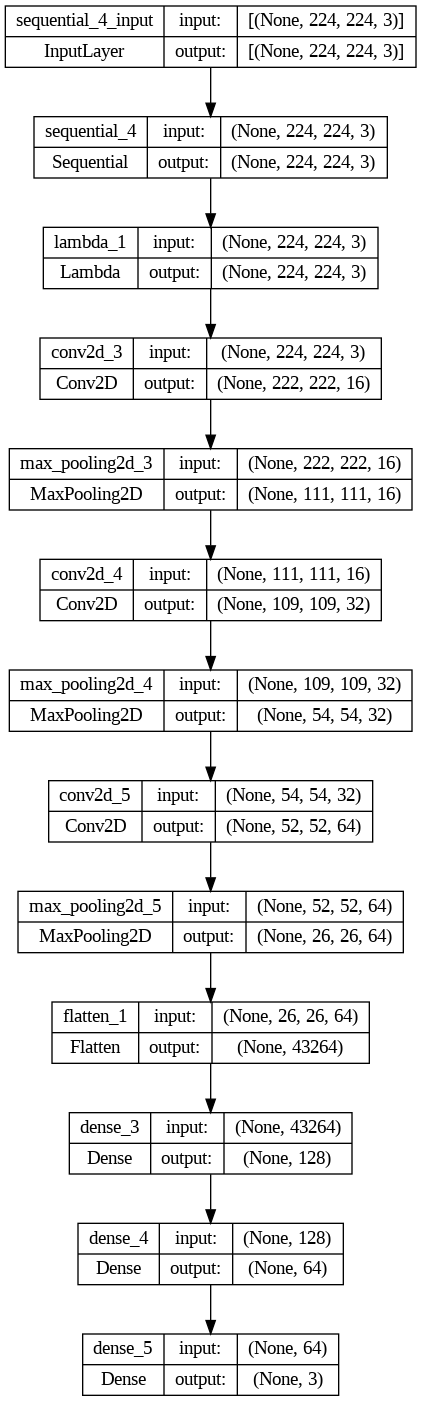

In [19]:
custom_model0 = CustomModel(pretrained_model=None, hidden_layers=[128, 64], dropout=[0.0, 0.0], pooling='flatten')
model_0 = custom_model0.generate_model()
model_0.summary()

from keras.utils import plot_model

plot_model(model_0, to_file='model_plot0.png', show_shapes=True, show_layer_names=True)


In [20]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model_0, legend=True)
visualkeras.layered_view(model_0, legend=True).save('model_visualization.png')

In [21]:
checkpoint_callback = ModelCheckpoint(results_path + '/model_0.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.2, min_lr=1e-8)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

history0 = custom_model0.train(model=model_0, epochs = 100, optimizer=optimizer, callbacks=[early_stopping, checkpoint_callback, reduce_lr])

Epoch 1/100
51/52 [============================>.] - ETA: 0s - loss: 9.9138 - accuracy: 0.4577 
Epoch 1: val_loss improved from inf to 0.87102, saving model to /content/drive/My Drive/model_0.h5
52/52 [==============================] - 4s 62ms/step - loss: 9.8372 - accuracy: 0.4581 - val_loss: 0.8710 - val_accuracy: 0.5354 - lr: 0.0010
Epoch 2/100
51/52 [============================>.] - ETA: 0s - loss: 0.9342 - accuracy: 0.4822
Epoch 2: val_loss improved from 0.87102 to 0.80953, saving model to /content/drive/My Drive/model_0.h5
52/52 [==============================] - 2s 33ms/step - loss: 0.9350 - accuracy: 0.4818 - val_loss: 0.8095 - val_accuracy: 0.5212 - lr: 0.0010
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 0.9352 - accuracy: 0.4669
Epoch 3: val_loss did not improve from 0.80953
52/52 [==============================] - 1s 29ms/step - loss: 0.9343 - accuracy: 0.4684 - val_loss: 1.0087 - val_accuracy: 0.5212 - lr: 0.0010
Epoch 4/100
51/52 [=================

## 0.2. Mostrem els resultats

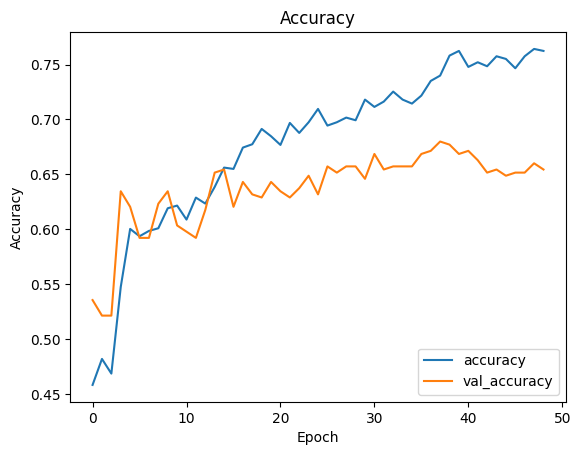

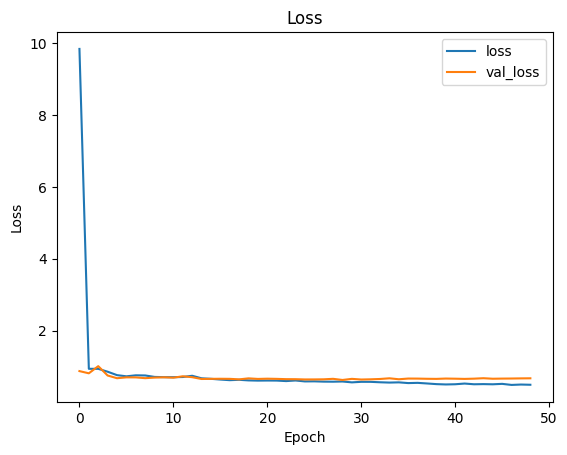

1/1 [==============================] - 0s 87ms/step


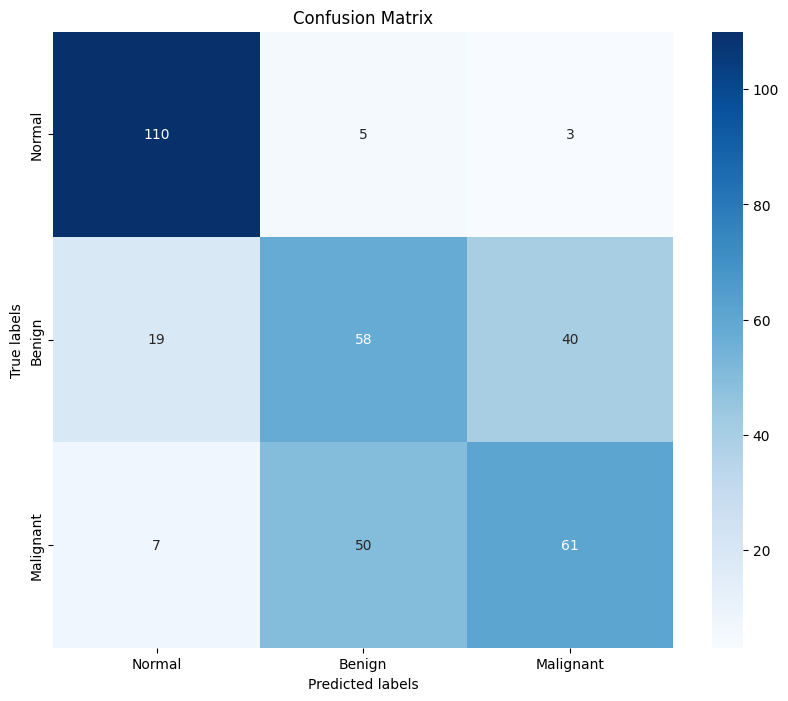

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       118
           1       0.51      0.50      0.50       117
           2       0.59      0.52      0.55       118

    accuracy                           0.65       353
   macro avg       0.64      0.65      0.64       353
weighted avg       0.64      0.65      0.64       353

12/12 [==============================] - 0s 10ms/step - loss: 0.6970 - accuracy: 0.6487
Pèrdua en el conjunt de dades de test: 0.6970242857933044
Precisió en el conjunt de dades de test: 0.6487252116203308


In [22]:
custom_model0.full_report(model=model_0, history=history0)


# 1. Model InceptionV3

## 1.1. Creem el model i entrenem

In [23]:
custom_model = CustomModel(pretrained_model='inception', hidden_layers=[144, 144, 144], dropout=[0.0, 0.1, 0.3], pooling='flatten')
model_inception = custom_model.generate_model()
model_inception.summary()

checkpoint_callback = ModelCheckpoint(results_path + '/model_inception0_patch.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.2, min_lr=1e-8)

history = custom_model.train(model=model_inception, epochs = 100, optimizer=optimizer, callbacks=[early_stopping, reduce_lr, checkpoint_callback])

87910968/87910968 [==============================] - 5s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 144)               7372944   
                                                                 
 dense_7 (Dense)             (None, 144)               20880     
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 19s 193ms/step - loss: 2.4346 - accuracy: 0.4787 - val_loss: 0.9707 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 2/100
51/52 [============================>.] - ETA: 0s - loss: 0.9828 - accuracy: 0.5564
Epoch 2: val_loss improved from 0.97068 to 0.87922, saving model to /content/drive/My Drive/model_inception0_patch.h5
52/52 [==============================] - 5s 102ms/step - loss: 0.9822 - accuracy: 0.5565 - val_loss: 0.8792 - val_accuracy: 0.5524 - lr: 0.0010
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 0.9051 - accuracy: 0.5680
Epoch 3: val_loss improved from 0.87922 to 0.75633, saving model to /content/drive/My Drive/model_inception0_patch.h5
52/52 [==============================] - 5s 101ms/step - loss: 0.9033 - accuracy: 0.5680 - val_loss: 0.7563 - val_accuracy: 0.5722 - lr: 0.0010
Epoch 4/100
51/52 [============================>.] - ETA: 0s - loss: 0.8392 - accuracy: 0.5827
Epoch 4: val_loss did not improve from 0.75633

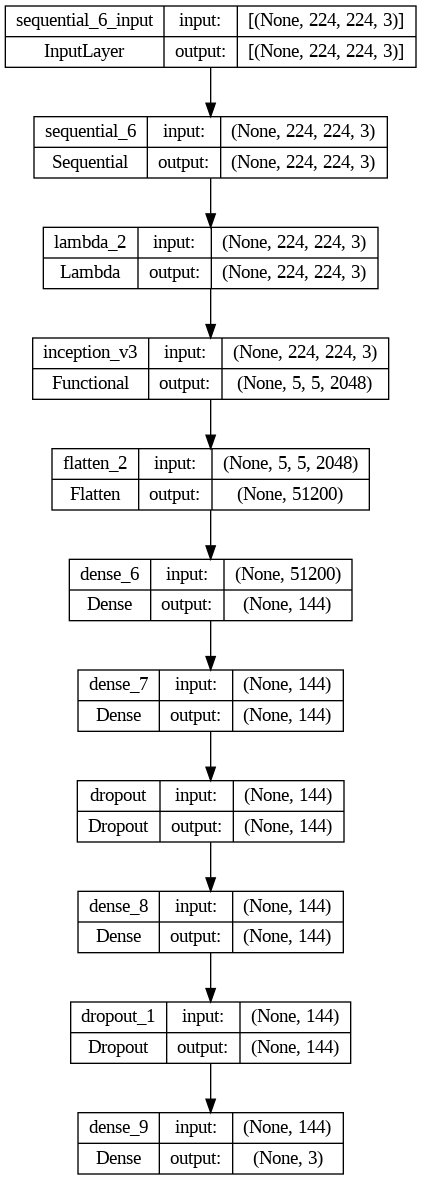

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model_inception, to_file='model_inception.png', show_shapes=True, show_layer_names=True)

## 1.2. Avaluem els resultats

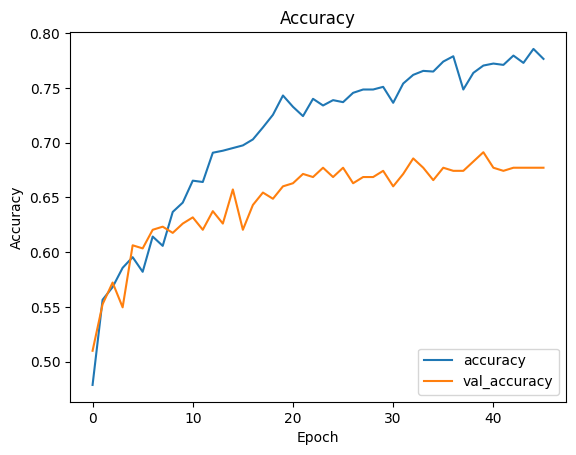

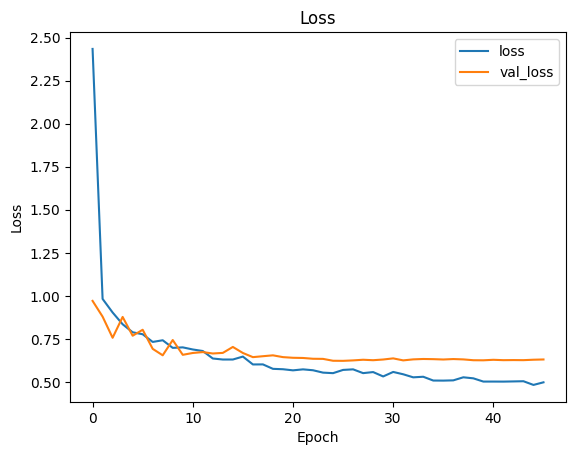

1/1 [==============================] - 1s 1s/step


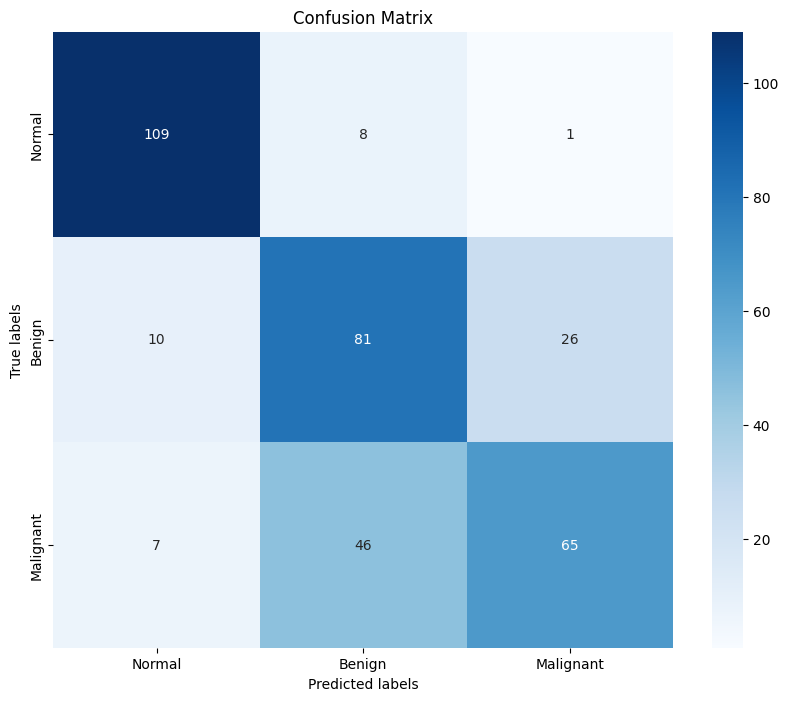

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       118
           1       0.60      0.69      0.64       117
           2       0.71      0.55      0.62       118

    accuracy                           0.72       353
   macro avg       0.72      0.72      0.72       353
weighted avg       0.72      0.72      0.72       353

12/12 [==============================] - 1s 62ms/step - loss: 0.5875 - accuracy: 0.7224
Pèrdua en el conjunt de dades de test: 0.5875271558761597
Precisió en el conjunt de dades de test: 0.7223796248435974


In [25]:
custom_model.full_report(model_inception, history)

## 1.3. Observem les capes del model base

In [26]:
custom_model.show_layers(model_inception.layers[2])

Layer 0: input_1 - Trainable: False
Layer 1: conv2d_6 - Trainable: False
Layer 2: batch_normalization - Trainable: False
Layer 3: activation - Trainable: False
Layer 4: conv2d_7 - Trainable: False
Layer 5: batch_normalization_1 - Trainable: False
Layer 6: activation_1 - Trainable: False
Layer 7: conv2d_8 - Trainable: False
Layer 8: batch_normalization_2 - Trainable: False
Layer 9: activation_2 - Trainable: False
Layer 10: max_pooling2d_6 - Trainable: False
Layer 11: conv2d_9 - Trainable: False
Layer 12: batch_normalization_3 - Trainable: False
Layer 13: activation_3 - Trainable: False
Layer 14: conv2d_10 - Trainable: False
Layer 15: batch_normalization_4 - Trainable: False
Layer 16: activation_4 - Trainable: False
Layer 17: max_pooling2d_7 - Trainable: False
Layer 18: conv2d_14 - Trainable: False
Layer 19: batch_normalization_8 - Trainable: False
Layer 20: activation_8 - Trainable: False
Layer 21: conv2d_12 - Trainable: False
Layer 22: conv2d_15 - Trainable: False
Layer 23: batch_norma

## 1.5. Descongelem l'últim bloc

In [27]:
inception_retrained1 = custom_model.freeze_layers(model_initial=model_inception, num_layers_to_freeze = 275)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
history2 = custom_model.train(model=inception_retrained1, optimizer=optimizer, epochs = 20)
custom_model.show_layers(inception_retrained1.layers[2])

Epoch 1/20
52/52 [==============================] - 12s 123ms/step - loss: 0.6056 - accuracy: 0.7151 - val_loss: 0.6364 - val_accuracy: 0.6799
Epoch 2/20
52/52 [==============================] - 5s 93ms/step - loss: 0.5674 - accuracy: 0.7345 - val_loss: 0.6303 - val_accuracy: 0.6771
Epoch 3/20
52/52 [==============================] - 5s 94ms/step - loss: 0.5561 - accuracy: 0.7418 - val_loss: 0.6282 - val_accuracy: 0.6714
Epoch 4/20
52/52 [==============================] - 5s 94ms/step - loss: 0.5497 - accuracy: 0.7454 - val_loss: 0.6277 - val_accuracy: 0.6657
Epoch 5/20
52/52 [==============================] - 5s 95ms/step - loss: 0.5575 - accuracy: 0.7533 - val_loss: 0.6247 - val_accuracy: 0.6572
Epoch 6/20
52/52 [==============================] - 5s 95ms/step - loss: 0.5387 - accuracy: 0.7570 - val_loss: 0.6248 - val_accuracy: 0.6686
Epoch 7/20
52/52 [==============================] - 5s 95ms/step - loss: 0.5334 - accuracy: 0.7509 - val_loss: 0.6270 - val_accuracy: 0.6686
Epoch 8/20


### Avaluem resultats

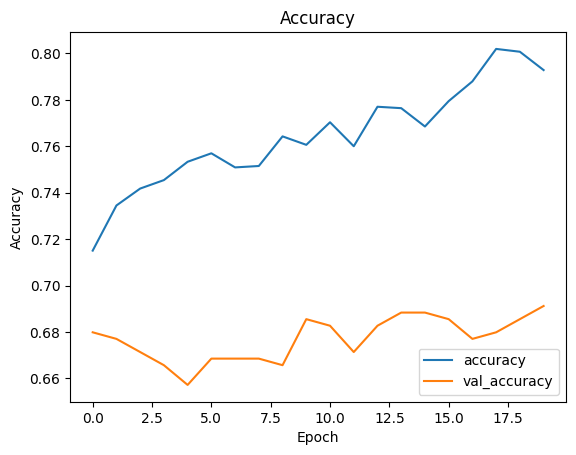

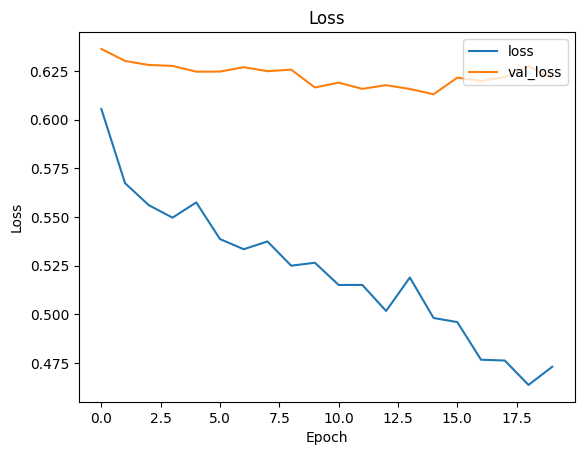

1/1 [==============================] - 2s 2s/step


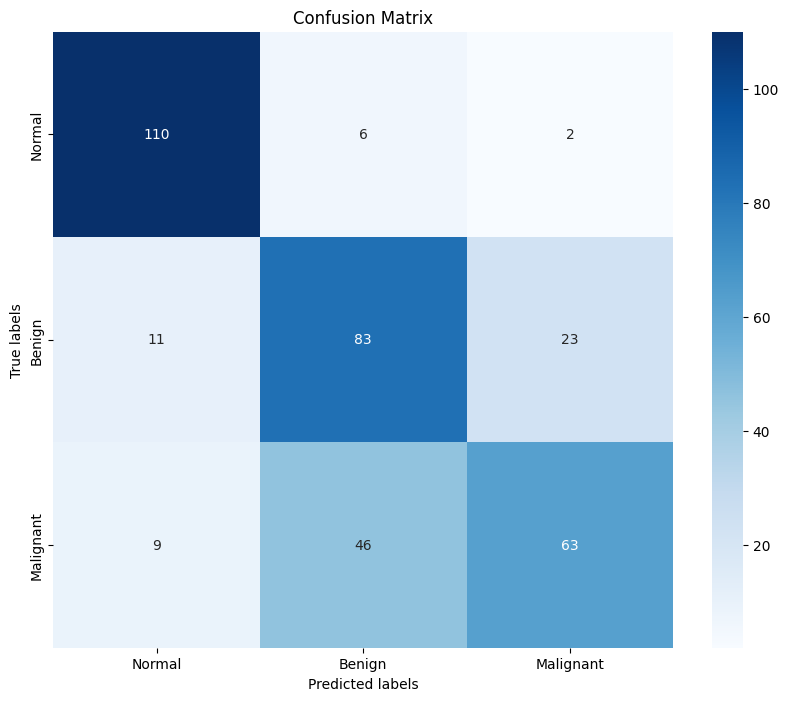

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       118
           1       0.61      0.71      0.66       117
           2       0.72      0.53      0.61       118

    accuracy                           0.73       353
   macro avg       0.73      0.73      0.72       353
weighted avg       0.73      0.73      0.72       353

12/12 [==============================] - 1s 62ms/step - loss: 0.5898 - accuracy: 0.7252
Pèrdua en el conjunt de dades de test: 0.589785635471344
Precisió en el conjunt de dades de test: 0.7252124547958374


In [28]:
custom_model.full_report(model=inception_retrained1, history=history2)

## 1.6. Descongelem els dos últims blocs

In [29]:
inception_retrained2 = custom_model.freeze_layers(model_initial=model_inception, num_layers_to_freeze = 247)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
history3 = custom_model.train(model=inception_retrained2, optimizer=optimizer, epochs = 20)
custom_model.show_layers(inception_retrained2.layers[2])

Epoch 1/20
52/52 [==============================] - 12s 131ms/step - loss: 0.6233 - accuracy: 0.7047 - val_loss: 0.6395 - val_accuracy: 0.6856
Epoch 2/20
52/52 [==============================] - 5s 103ms/step - loss: 0.5878 - accuracy: 0.7248 - val_loss: 0.6587 - val_accuracy: 0.6827
Epoch 3/20
52/52 [==============================] - 5s 103ms/step - loss: 0.5656 - accuracy: 0.7442 - val_loss: 0.6720 - val_accuracy: 0.6686
Epoch 4/20
52/52 [==============================] - 5s 103ms/step - loss: 0.5607 - accuracy: 0.7503 - val_loss: 0.6701 - val_accuracy: 0.6714
Epoch 5/20
52/52 [==============================] - 5s 104ms/step - loss: 0.5410 - accuracy: 0.7552 - val_loss: 0.6650 - val_accuracy: 0.6771
Epoch 6/20
52/52 [==============================] - 5s 104ms/step - loss: 0.5108 - accuracy: 0.7631 - val_loss: 0.6720 - val_accuracy: 0.6714
Epoch 7/20
52/52 [==============================] - 5s 104ms/step - loss: 0.5300 - accuracy: 0.7679 - val_loss: 0.6733 - val_accuracy: 0.6629
Epoch

### Avaluem resultats

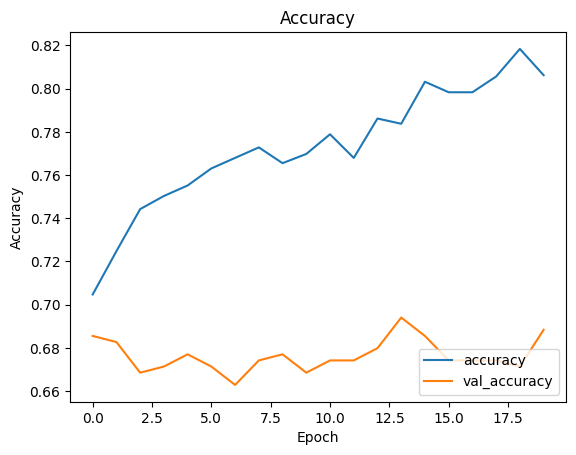

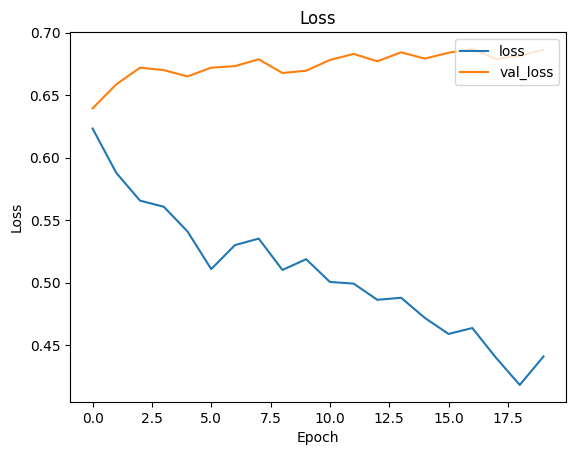

1/1 [==============================] - 1s 1s/step


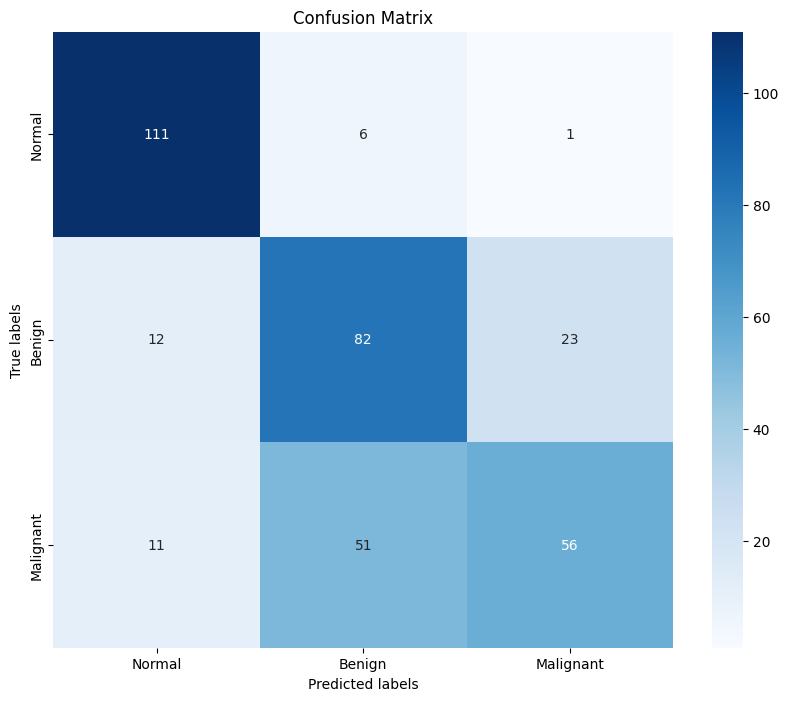

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       118
           1       0.59      0.70      0.64       117
           2       0.70      0.47      0.57       118

    accuracy                           0.71       353
   macro avg       0.71      0.71      0.70       353
weighted avg       0.71      0.71      0.70       353

12/12 [==============================] - 1s 62ms/step - loss: 0.6214 - accuracy: 0.7054
Pèrdua en el conjunt de dades de test: 0.6214364171028137
Precisió en el conjunt de dades de test: 0.7053824067115784


In [30]:
custom_model.full_report(model=inception_retrained2, history=history3)

## 1.7. Descongelem tot el model

In [31]:
inception_retrained3 = custom_model.freeze_layers(model_initial=model_inception, num_layers_to_freeze = 1)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
history4 = custom_model.train(model=inception_retrained3, optimizer=optimizer, epochs = 20)
custom_model.show_layers(inception_retrained2.layers[2])

Epoch 1/20
52/52 [==============================] - 29s 326ms/step - loss: 0.8820 - accuracy: 0.5996 - val_loss: 0.8629 - val_accuracy: 0.6317
Epoch 2/20
52/52 [==============================] - 13s 249ms/step - loss: 0.8071 - accuracy: 0.6367 - val_loss: 0.7954 - val_accuracy: 0.6487
Epoch 3/20
52/52 [==============================] - 13s 248ms/step - loss: 0.7622 - accuracy: 0.6361 - val_loss: 0.7584 - val_accuracy: 0.6771
Epoch 4/20
52/52 [==============================] - 13s 247ms/step - loss: 0.6841 - accuracy: 0.6622 - val_loss: 0.7310 - val_accuracy: 0.6657
Epoch 5/20
52/52 [==============================] - 13s 246ms/step - loss: 0.6921 - accuracy: 0.6738 - val_loss: 0.7034 - val_accuracy: 0.6714
Epoch 6/20
52/52 [==============================] - 13s 245ms/step - loss: 0.6659 - accuracy: 0.6865 - val_loss: 0.7120 - val_accuracy: 0.6714
Epoch 7/20
52/52 [==============================] - 13s 246ms/step - loss: 0.6366 - accuracy: 0.6974 - val_loss: 0.7136 - val_accuracy: 0.6629

### Avaluem resultats

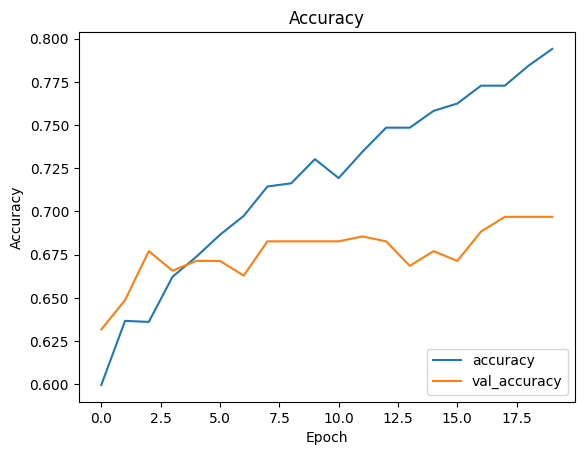

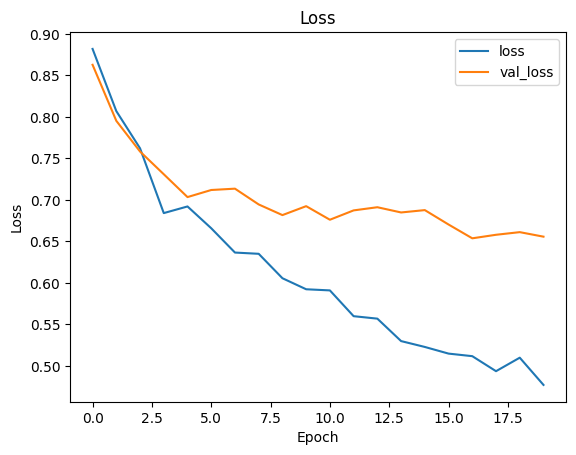

1/1 [==============================] - 1s 1s/step


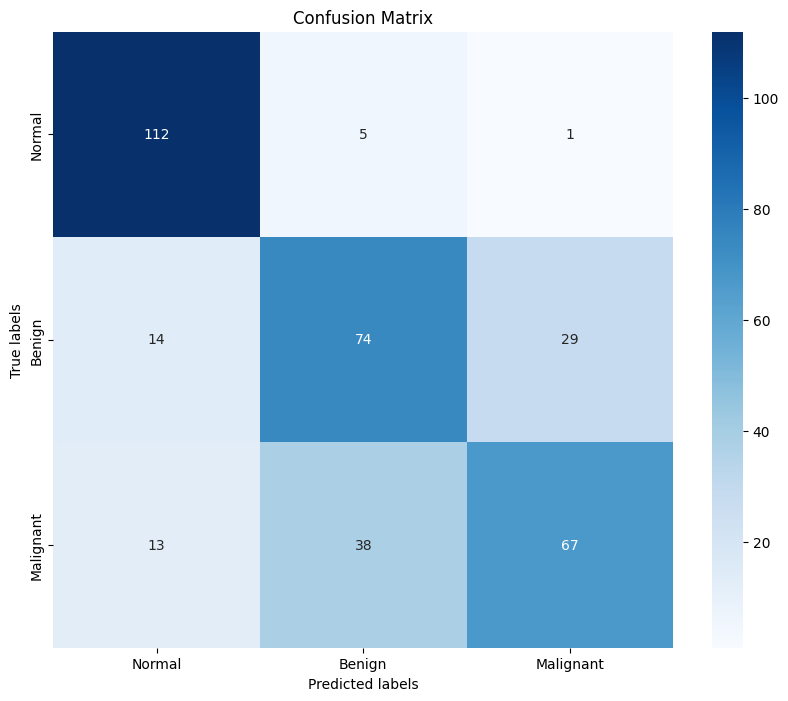

              precision    recall  f1-score   support

           0       0.81      0.95      0.87       118
           1       0.63      0.63      0.63       117
           2       0.69      0.57      0.62       118

    accuracy                           0.72       353
   macro avg       0.71      0.72      0.71       353
weighted avg       0.71      0.72      0.71       353

12/12 [==============================] - 1s 62ms/step - loss: 0.6294 - accuracy: 0.7167
Pèrdua en el conjunt de dades de test: 0.6293842196464539
Precisió en el conjunt de dades de test: 0.7167139053344727


In [32]:
custom_model.full_report(model=inception_retrained3, history=history4)

# 2. Model VGG19

## 2.1. Creem el model i entrenem

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 lambda_5 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_18 (Dense)            (None, 1680)              42149520  
                                                                 
 dropout_8 (Dropout)         (None, 1680)              0         
                                                                 
 dense_19 (Dense)            (None, 1424)            

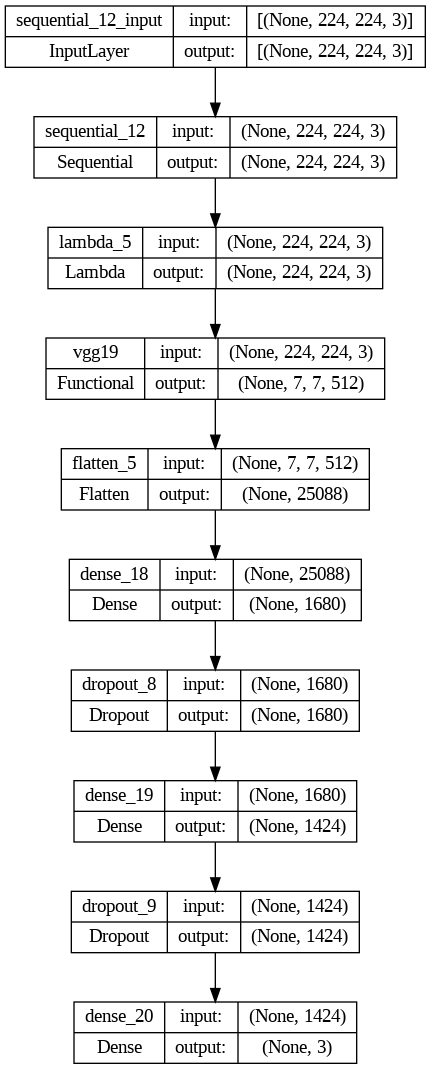

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.2, min_lr=1e-8)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
checkpoint_callback = ModelCheckpoint(results_path + '/model_vgg19_patches.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

custom_model2 = CustomModel(pretrained_model='vgg19', hidden_layers=[1680, 1424], dropout=[0.2, 0.4], pooling='flatten')
model_vgg19 = custom_model2.generate_model()
model_vgg19.summary()

plot_model(model_vgg19, to_file='model_vgg19.png', show_shapes=True, show_layer_names=True)


In [46]:
history5 = custom_model2.train(model=model_vgg19, epochs = 100, optimizer=optimizer, callbacks=[early_stopping, reduce_lr, checkpoint_callback])


Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 10.7180 - accuracy: 0.5079
Epoch 1: val_loss improved from inf to 0.78550, saving model to /content/drive/My Drive/model_vgg19_patches.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 13s 228ms/step - loss: 10.7180 - accuracy: 0.5079 - val_loss: 0.7855 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 0.9143 - accuracy: 0.5772
Epoch 2: val_loss improved from 0.78550 to 0.77412, saving model to /content/drive/My Drive/model_vgg19_patches.h5
52/52 [==============================] - 11s 221ms/step - loss: 0.9143 - accuracy: 0.5772 - val_loss: 0.7741 - val_accuracy: 0.6317 - lr: 0.0010
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.8049 - accuracy: 0.6282
Epoch 3: val_loss improved from 0.77412 to 0.68355, saving model to /content/drive/My Drive/model_vgg19_patches.h5
52/52 [==============================] - 12s 224ms/step - loss: 0.8049 - accuracy: 0.6282 - val_loss: 0.6836 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 0.7647 - accuracy: 0.6160
Epoch 4: val_loss did not improve from 0.68355
52

## 2.2. Mostrem els resultats

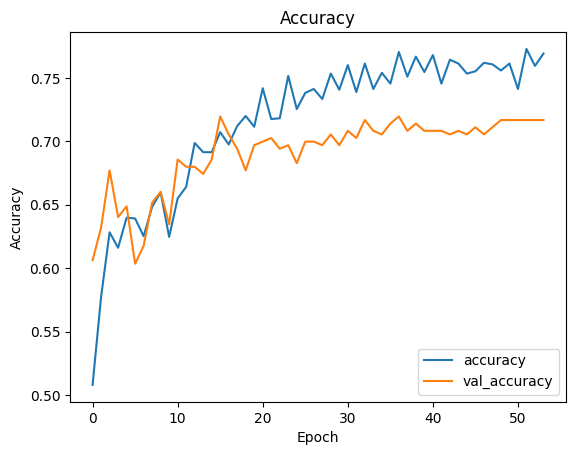

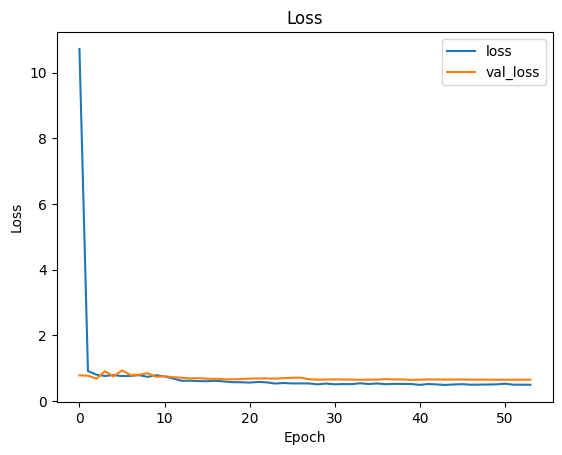

1/1 [==============================] - 0s 185ms/step


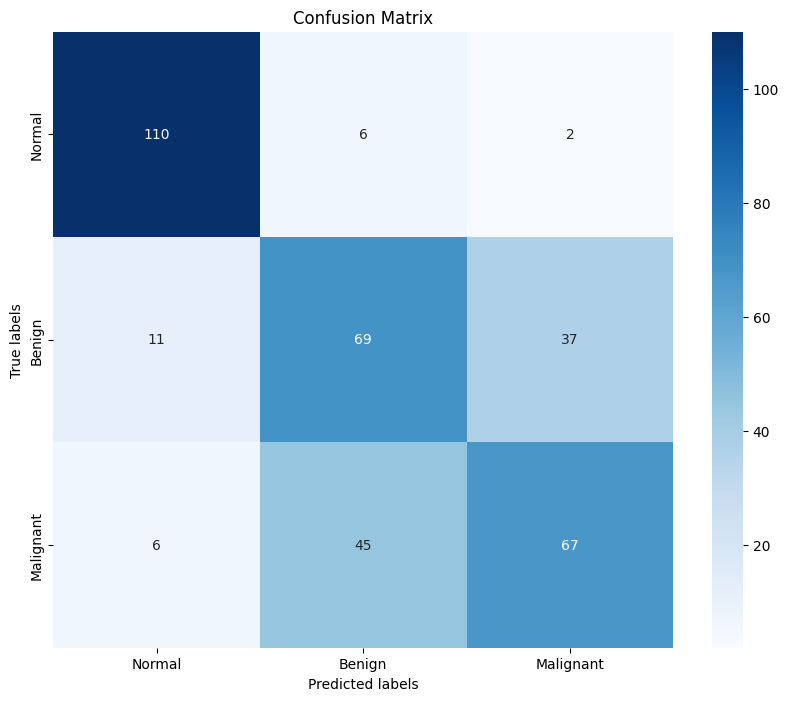

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       118
           1       0.57      0.59      0.58       117
           2       0.63      0.57      0.60       118

    accuracy                           0.70       353
   macro avg       0.69      0.70      0.69       353
weighted avg       0.69      0.70      0.69       353

12/12 [==============================] - 2s 139ms/step - loss: 0.6587 - accuracy: 0.6969
Pèrdua en el conjunt de dades de test: 0.6586992144584656
Precisió en el conjunt de dades de test: 0.6968838572502136


In [47]:
custom_model2.full_report(model=model_vgg19, history=history5)

## 2.3. Observem les capes del model base

In [48]:
custom_model2.show_layers(model_vgg19.layers[2])

Layer 0: input_4 - Trainable: False
Layer 1: block1_conv1 - Trainable: False
Layer 2: block1_conv2 - Trainable: False
Layer 3: block1_pool - Trainable: False
Layer 4: block2_conv1 - Trainable: False
Layer 5: block2_conv2 - Trainable: False
Layer 6: block2_pool - Trainable: False
Layer 7: block3_conv1 - Trainable: False
Layer 8: block3_conv2 - Trainable: False
Layer 9: block3_conv3 - Trainable: False
Layer 10: block3_conv4 - Trainable: False
Layer 11: block3_pool - Trainable: False
Layer 12: block4_conv1 - Trainable: False
Layer 13: block4_conv2 - Trainable: False
Layer 14: block4_conv3 - Trainable: False
Layer 15: block4_conv4 - Trainable: False
Layer 16: block4_pool - Trainable: False
Layer 17: block5_conv1 - Trainable: False
Layer 18: block5_conv2 - Trainable: False
Layer 19: block5_conv3 - Trainable: False
Layer 20: block5_conv4 - Trainable: False
Layer 21: block5_pool - Trainable: False


## 2.4. Congelem les capes fins a la 16 i reentrenem l'últim bloc

In [49]:
model_retrained_vgg1 = custom_model2.freeze_layers(model_initial=model_vgg19, num_layers_to_freeze = 16)

## 2.5. Reentrenem el model amb 20 epcochs més i un lr baix

---



In [50]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)

history6 = custom_model2.train(model=model_retrained_vgg1, optimizer=optimizer, epochs = 20)

custom_model2.show_layers(model_retrained_vgg1.layers[2])


Epoch 1/20
52/52 [==============================] - 14s 233ms/step - loss: 0.5357 - accuracy: 0.7400 - val_loss: 0.6595 - val_accuracy: 0.7054
Epoch 2/20
52/52 [==============================] - 12s 224ms/step - loss: 0.5338 - accuracy: 0.7503 - val_loss: 0.6498 - val_accuracy: 0.6912
Epoch 3/20
52/52 [==============================] - 12s 224ms/step - loss: 0.5269 - accuracy: 0.7467 - val_loss: 0.6365 - val_accuracy: 0.7139
Epoch 4/20
52/52 [==============================] - 12s 224ms/step - loss: 0.5107 - accuracy: 0.7576 - val_loss: 0.6441 - val_accuracy: 0.6969
Epoch 5/20
52/52 [==============================] - 12s 224ms/step - loss: 0.5017 - accuracy: 0.7564 - val_loss: 0.6451 - val_accuracy: 0.7082
Epoch 6/20
52/52 [==============================] - 12s 224ms/step - loss: 0.4631 - accuracy: 0.7837 - val_loss: 0.7079 - val_accuracy: 0.6997
Epoch 7/20
52/52 [==============================] - 12s 223ms/step - loss: 0.4601 - accuracy: 0.7861 - val_loss: 0.6759 - val_accuracy: 0.7139

### Avaluem resultats

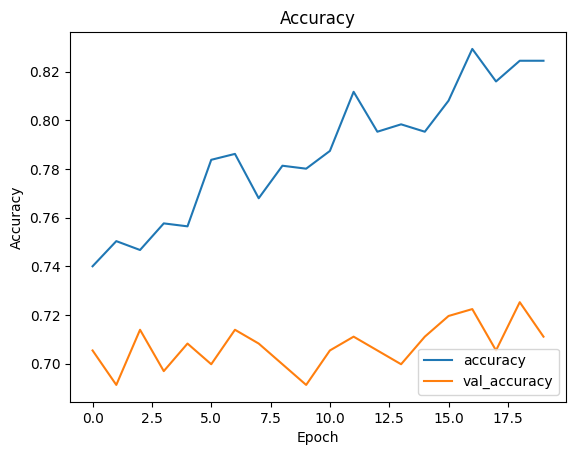

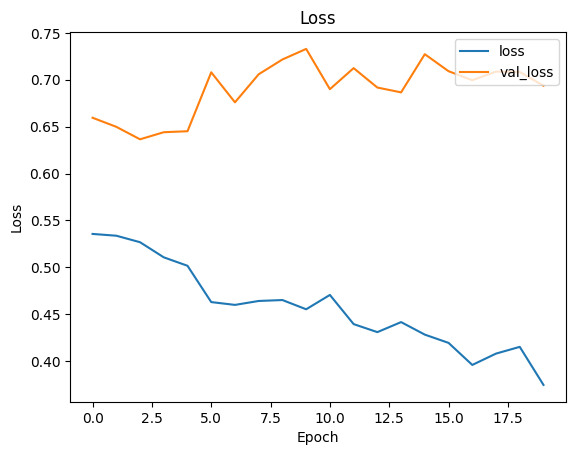

1/1 [==============================] - 0s 176ms/step


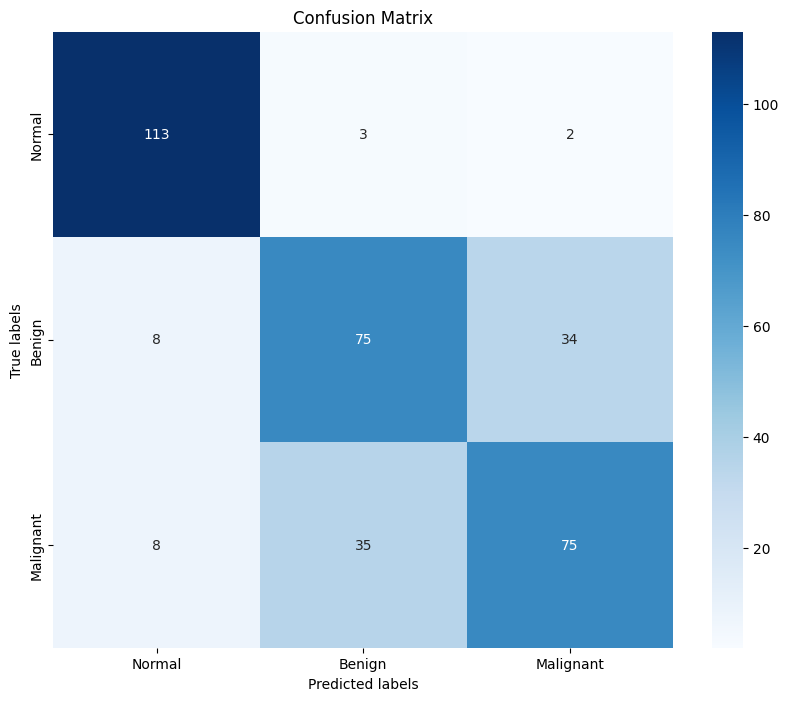

              precision    recall  f1-score   support

           0       0.88      0.96      0.91       118
           1       0.66      0.64      0.65       117
           2       0.68      0.64      0.66       118

    accuracy                           0.75       353
   macro avg       0.74      0.74      0.74       353
weighted avg       0.74      0.75      0.74       353

12/12 [==============================] - 2s 140ms/step - loss: 0.7147 - accuracy: 0.7450
Pèrdua en el conjunt de dades de test: 0.7146517634391785
Precisió en el conjunt de dades de test: 0.7450425028800964


In [51]:
custom_model2.full_report(model=model_retrained_vgg1, history=history6)

## 2.6. Repetim el procediment descongelant els dos últims blocs

In [52]:
model_retrained_vgg2 = custom_model2.freeze_layers(model_initial=model_vgg19, num_layers_to_freeze = 11)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)

history7 = custom_model2.train(model=model_retrained_vgg2, optimizer=optimizer, epochs = 20)

custom_model2.show_layers(model_retrained_vgg2.layers[2])

Epoch 1/20
52/52 [==============================] - 20s 320ms/step - loss: 0.4289 - accuracy: 0.7977 - val_loss: 0.7106 - val_accuracy: 0.7224
Epoch 2/20
52/52 [==============================] - 15s 294ms/step - loss: 0.4110 - accuracy: 0.8190 - val_loss: 0.6329 - val_accuracy: 0.7195
Epoch 3/20
52/52 [==============================] - 15s 294ms/step - loss: 0.3975 - accuracy: 0.8293 - val_loss: 0.6599 - val_accuracy: 0.7365
Epoch 4/20
52/52 [==============================] - 15s 294ms/step - loss: 0.4084 - accuracy: 0.8086 - val_loss: 0.7756 - val_accuracy: 0.7309
Epoch 5/20
52/52 [==============================] - 15s 294ms/step - loss: 0.3926 - accuracy: 0.8250 - val_loss: 0.8813 - val_accuracy: 0.7025
Epoch 6/20
52/52 [==============================] - 15s 294ms/step - loss: 0.3805 - accuracy: 0.8335 - val_loss: 0.8336 - val_accuracy: 0.6912
Epoch 7/20
52/52 [==============================] - 15s 294ms/step - loss: 0.3686 - accuracy: 0.8275 - val_loss: 0.7032 - val_accuracy: 0.7337

## 2.7. Tornem a mostrar els resultats després del fine tuning

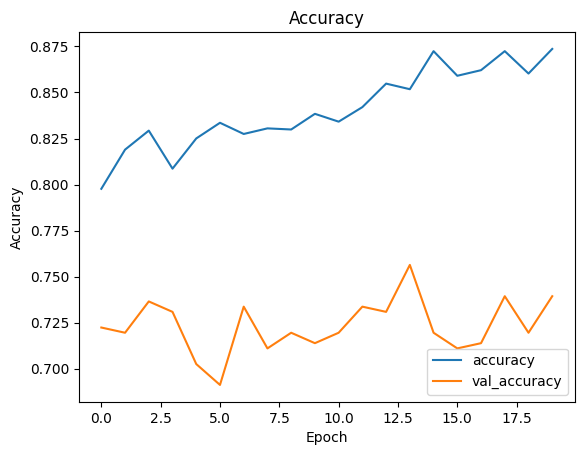

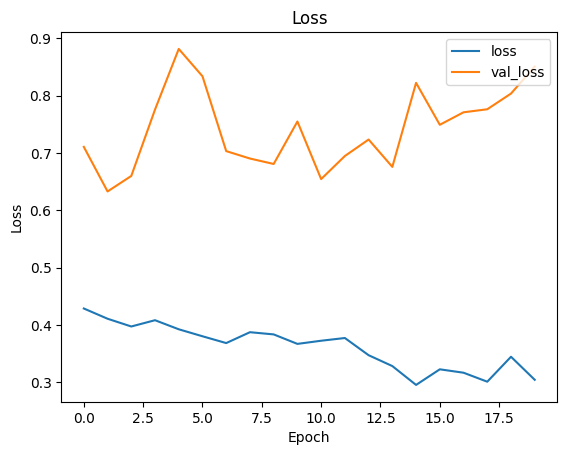

1/1 [==============================] - 0s 171ms/step


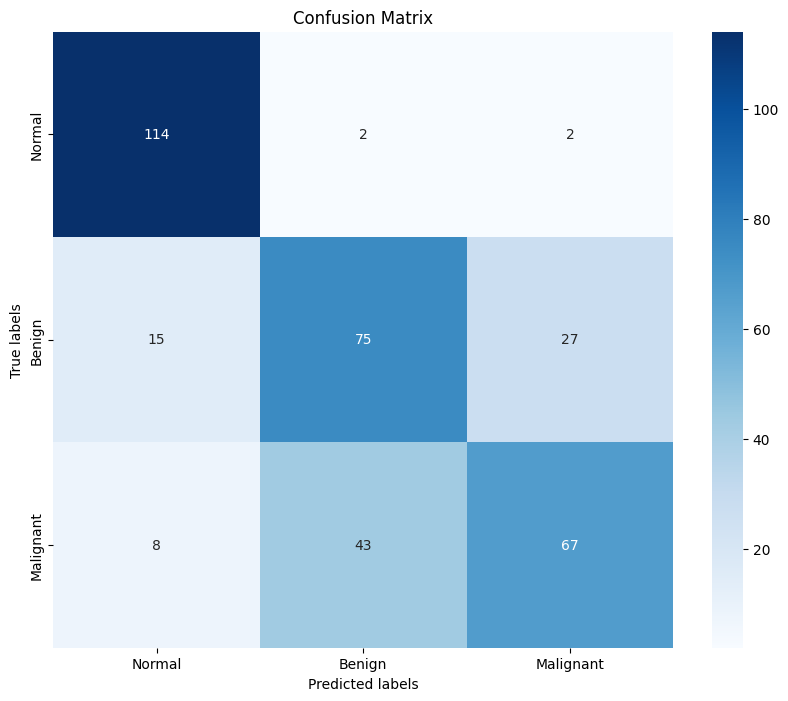

              precision    recall  f1-score   support

           0       0.83      0.97      0.89       118
           1       0.62      0.64      0.63       117
           2       0.70      0.57      0.63       118

    accuracy                           0.73       353
   macro avg       0.72      0.72      0.72       353
weighted avg       0.72      0.73      0.72       353

12/12 [==============================] - 2s 139ms/step - loss: 0.9298 - accuracy: 0.7252
Pèrdua en el conjunt de dades de test: 0.9297778606414795
Precisió en el conjunt de dades de test: 0.7252124547958374


In [53]:
custom_model2.full_report(model=model_retrained_vgg2, history=history7)

## 2.8. Descongelem tot el model

In [54]:
model_retrained_vgg3 = custom_model2.freeze_layers(model_initial=model_vgg19, num_layers_to_freeze = 1)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)

history8 = custom_model2.train(model=model_retrained_vgg3, optimizer=optimizer, epochs = 20)

custom_model2.show_layers(model_retrained_vgg3.layers[2])

Epoch 1/20
52/52 [==============================] - 44s 639ms/step - loss: 0.3250 - accuracy: 0.8597 - val_loss: 0.8744 - val_accuracy: 0.7224
Epoch 2/20
52/52 [==============================] - 28s 533ms/step - loss: 0.3143 - accuracy: 0.8663 - val_loss: 0.7335 - val_accuracy: 0.7422
Epoch 3/20
52/52 [==============================] - 28s 532ms/step - loss: 0.3057 - accuracy: 0.8694 - val_loss: 0.8045 - val_accuracy: 0.7224
Epoch 4/20
52/52 [==============================] - 28s 533ms/step - loss: 0.3293 - accuracy: 0.8736 - val_loss: 0.7718 - val_accuracy: 0.7394
Epoch 5/20
52/52 [==============================] - 28s 533ms/step - loss: 0.3022 - accuracy: 0.8682 - val_loss: 0.6869 - val_accuracy: 0.7025
Epoch 6/20
52/52 [==============================] - 28s 533ms/step - loss: 0.2708 - accuracy: 0.8767 - val_loss: 0.8803 - val_accuracy: 0.7365
Epoch 7/20
52/52 [==============================] - 28s 532ms/step - loss: 0.2907 - accuracy: 0.8858 - val_loss: 0.7919 - val_accuracy: 0.7450

### Avaluem els resultats

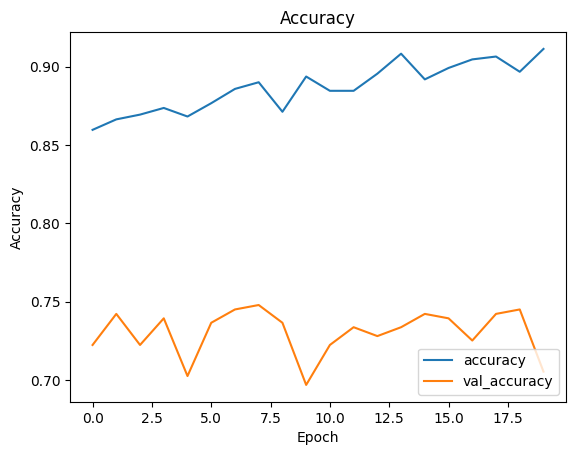

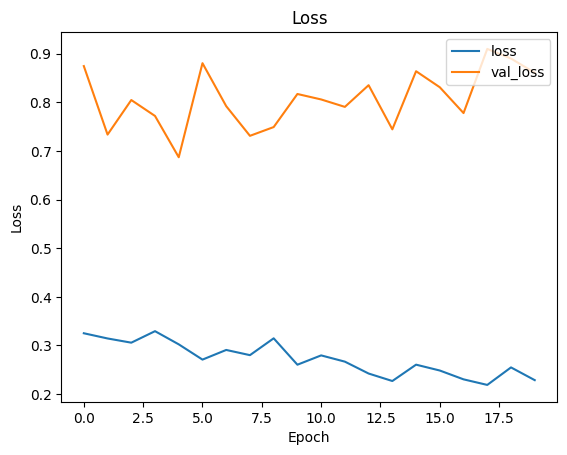

1/1 [==============================] - 0s 169ms/step


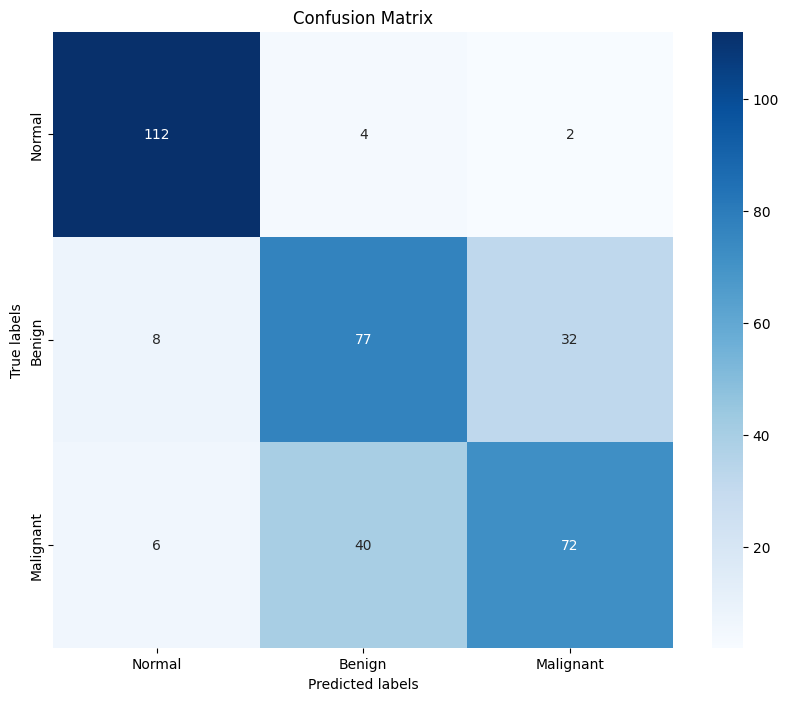

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       118
           1       0.64      0.66      0.65       117
           2       0.68      0.61      0.64       118

    accuracy                           0.74       353
   macro avg       0.73      0.74      0.74       353
weighted avg       0.74      0.74      0.74       353

12/12 [==============================] - 2s 139ms/step - loss: 0.9456 - accuracy: 0.7394
Pèrdua en el conjunt de dades de test: 0.9456267356872559
Precisió en el conjunt de dades de test: 0.7393767833709717


In [55]:
custom_model2.full_report(model=model_retrained_vgg3, history=history8)

# 3. Efficientnet B2

## 3.1. Creem el model i entrenem

In [35]:
results_path = '/content/drive/My Drive'
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.2, min_lr=1e-8)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
checkpoint_callback = ModelCheckpoint(results_path + '/model_effic_patch.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

custom_model3 = CustomModel(pretrained_model='efficientnetb2', hidden_layers=[1296, 1168, 1424], dropout=[0.1, 0.1, 0.3], pooling='flatten')
model_effic = custom_model3.generate_model()
model_effic.summary()

history9 = custom_model3.train(model=model_effic, epochs = 100, optimizer=optimizer, callbacks=[early_stopping, reduce_lr, checkpoint_callback])


31790344/31790344 [==============================] - 2s 0us/step
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 lambda_4 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 68992)             0         
                                                                 
 dense_14 (Dense)            (None, 1296)              89414928  
                                                                 
 dropout_5 (Dropout)         (None, 1296)             

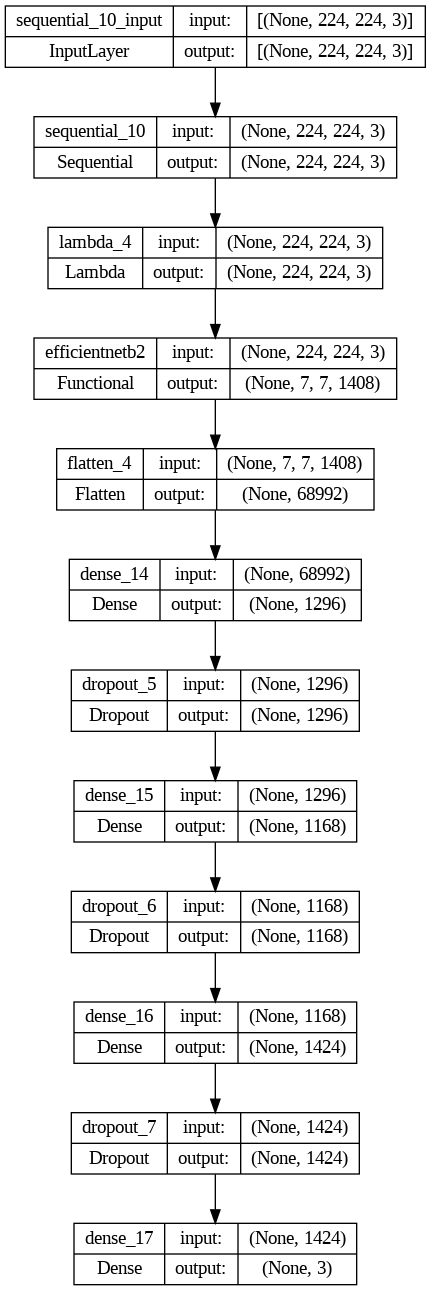

In [36]:
plot_model(model_effic, to_file='model_effic.png', show_shapes=True, show_layer_names=True)

## 3.2. Mostrem els resultats

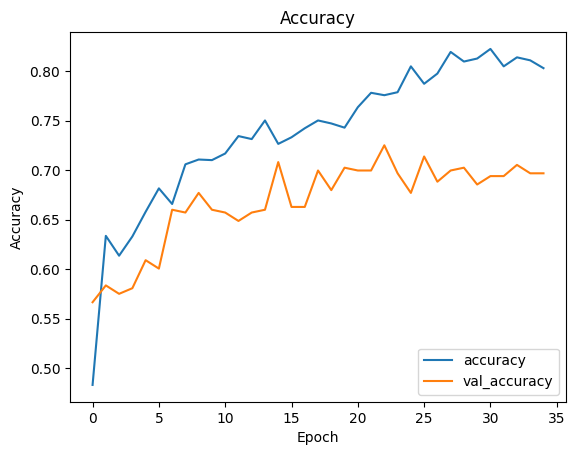

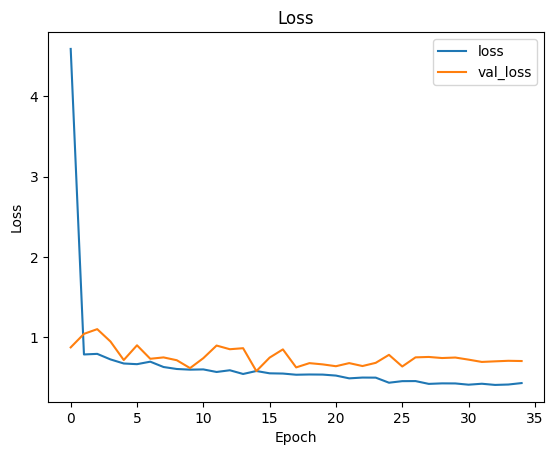

1/1 [==============================] - 2s 2s/step


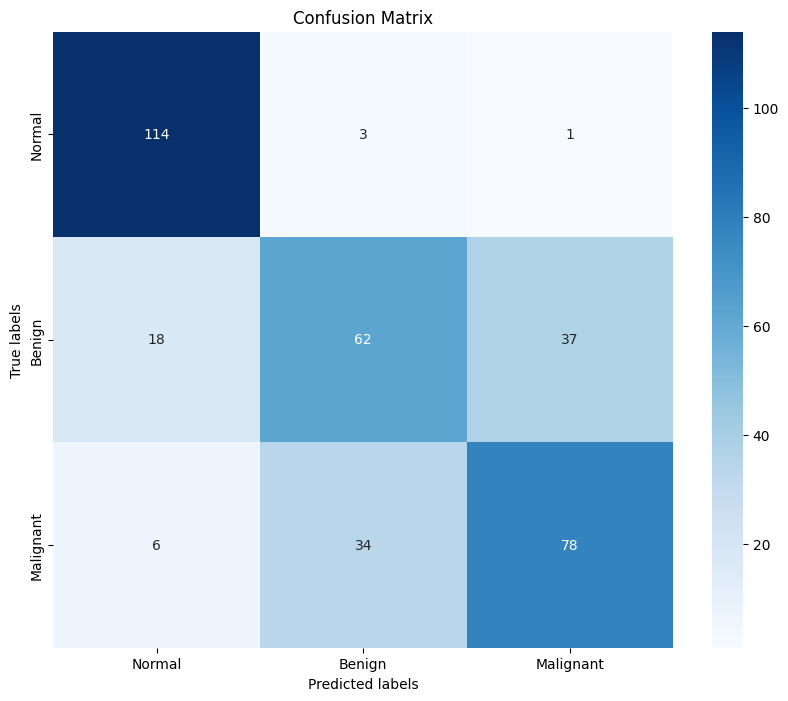

              precision    recall  f1-score   support

           0       0.83      0.97      0.89       118
           1       0.63      0.53      0.57       117
           2       0.67      0.66      0.67       118

    accuracy                           0.72       353
   macro avg       0.71      0.72      0.71       353
weighted avg       0.71      0.72      0.71       353

12/12 [==============================] - 1s 79ms/step - loss: 0.5727 - accuracy: 0.7195
Pèrdua en el conjunt de dades de test: 0.5727003216743469
Precisió en el conjunt de dades de test: 0.7195467352867126


In [37]:
custom_model3.full_report(model=model_effic, history=history9)

## 3.3. Mostrem les capes del model base

In [38]:
custom_model3.show_layers(model_effic.layers[2])

Layer 0: input_3 - Trainable: False
Layer 1: rescaling - Trainable: False
Layer 2: normalization - Trainable: False
Layer 3: rescaling_1 - Trainable: False
Layer 4: stem_conv_pad - Trainable: False
Layer 5: stem_conv - Trainable: False
Layer 6: stem_bn - Trainable: False
Layer 7: stem_activation - Trainable: False
Layer 8: block1a_dwconv - Trainable: False
Layer 9: block1a_bn - Trainable: False
Layer 10: block1a_activation - Trainable: False
Layer 11: block1a_se_squeeze - Trainable: False
Layer 12: block1a_se_reshape - Trainable: False
Layer 13: block1a_se_reduce - Trainable: False
Layer 14: block1a_se_expand - Trainable: False
Layer 15: block1a_se_excite - Trainable: False
Layer 16: block1a_project_conv - Trainable: False
Layer 17: block1a_project_bn - Trainable: False
Layer 18: block1b_dwconv - Trainable: False
Layer 19: block1b_bn - Trainable: False
Layer 20: block1b_activation - Trainable: False
Layer 21: block1b_se_squeeze - Trainable: False
Layer 22: block1b_se_reshape - Trainabl

## 3.4. Descongelem l'últim bloc

In [39]:
model_retrained_effic1 = custom_model3.freeze_layers(model_initial=model_effic, num_layers_to_freeze = 308)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)

history10 = custom_model3.train(model=model_retrained_effic1, optimizer=optimizer, epochs = 20)

custom_model3.show_layers(model_retrained_effic1.layers[2])

Epoch 1/20
52/52 [==============================] - 19s 177ms/step - loss: 1.5907 - accuracy: 0.6112 - val_loss: 0.6295 - val_accuracy: 0.6686
Epoch 2/20
52/52 [==============================] - 7s 136ms/step - loss: 1.1151 - accuracy: 0.6495 - val_loss: 0.6321 - val_accuracy: 0.6771
Epoch 3/20
52/52 [==============================] - 7s 138ms/step - loss: 0.9677 - accuracy: 0.6707 - val_loss: 0.6277 - val_accuracy: 0.6657
Epoch 4/20
52/52 [==============================] - 7s 138ms/step - loss: 0.7608 - accuracy: 0.6902 - val_loss: 0.6231 - val_accuracy: 0.6686
Epoch 5/20
52/52 [==============================] - 7s 138ms/step - loss: 0.7005 - accuracy: 0.7029 - val_loss: 0.6201 - val_accuracy: 0.6686
Epoch 6/20
52/52 [==============================] - 7s 137ms/step - loss: 0.6611 - accuracy: 0.7260 - val_loss: 0.6165 - val_accuracy: 0.6742
Epoch 7/20
52/52 [==============================] - 7s 136ms/step - loss: 0.6682 - accuracy: 0.7114 - val_loss: 0.6179 - val_accuracy: 0.6771
Epoch

### Avaluem els resultats

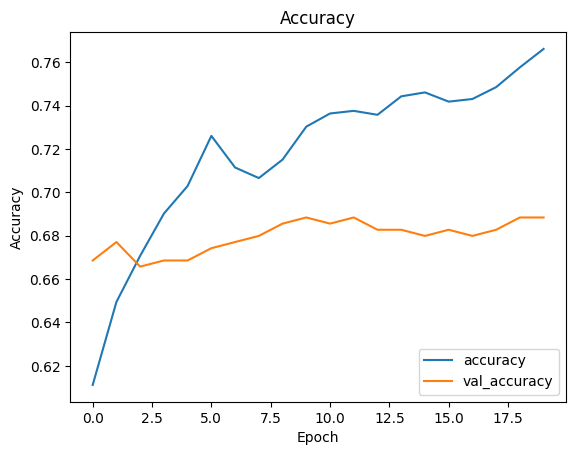

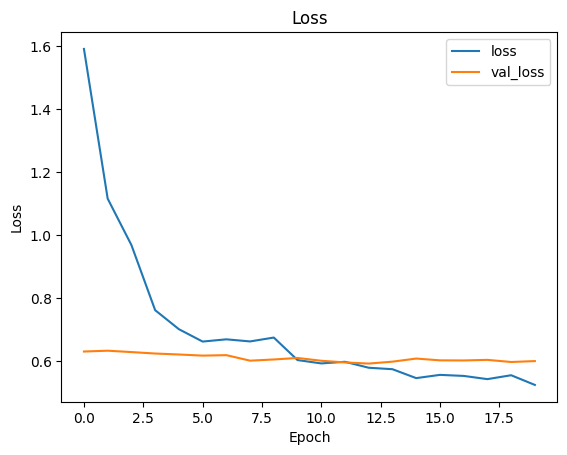

1/1 [==============================] - 2s 2s/step


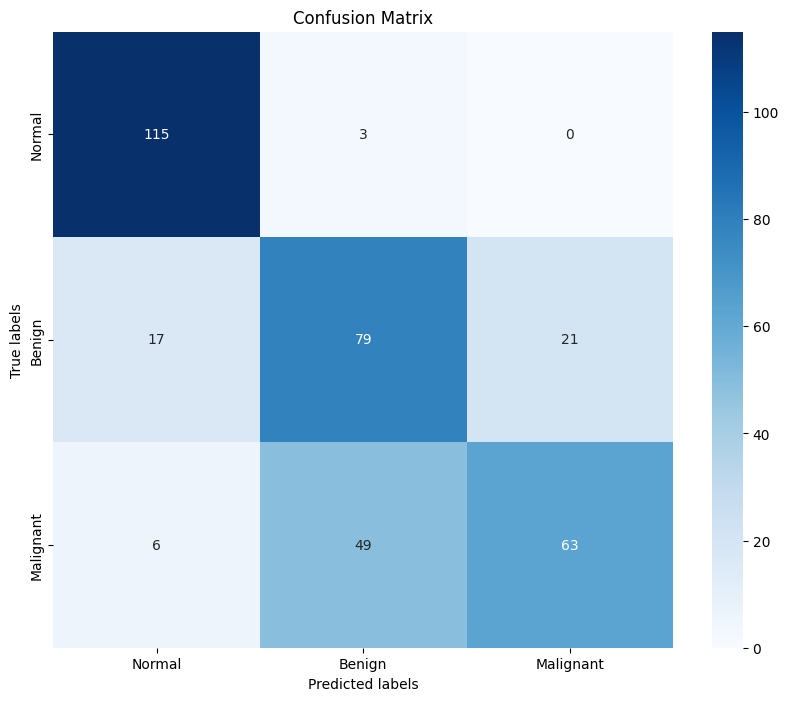

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       118
           1       0.60      0.68      0.64       117
           2       0.75      0.53      0.62       118

    accuracy                           0.73       353
   macro avg       0.73      0.73      0.72       353
weighted avg       0.73      0.73      0.72       353

12/12 [==============================] - 1s 77ms/step - loss: 0.5698 - accuracy: 0.7280
Pèrdua en el conjunt de dades de test: 0.5697575807571411
Precisió en el conjunt de dades de test: 0.7280453443527222


In [40]:
custom_model3.full_report(model=model_retrained_effic1, history=history10)

## 3.5. Descongelem els dos últims blocs

In [41]:
model_retrained_effic2 = custom_model3.freeze_layers(model_initial=model_effic, num_layers_to_freeze = 234)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)

history11 = custom_model3.train(model=model_retrained_effic2, optimizer=optimizer, epochs = 20)

custom_model3.show_layers(model_retrained_effic2.layers[2])

Epoch 1/20
52/52 [==============================] - 21s 200ms/step - loss: 0.8147 - accuracy: 0.6841 - val_loss: 0.6160 - val_accuracy: 0.6912
Epoch 2/20
52/52 [==============================] - 8s 160ms/step - loss: 0.7203 - accuracy: 0.7053 - val_loss: 0.6515 - val_accuracy: 0.6856
Epoch 3/20
52/52 [==============================] - 8s 162ms/step - loss: 0.6616 - accuracy: 0.7217 - val_loss: 0.7099 - val_accuracy: 0.6742
Epoch 4/20
52/52 [==============================] - 8s 162ms/step - loss: 0.6365 - accuracy: 0.7157 - val_loss: 0.7116 - val_accuracy: 0.6771
Epoch 5/20
52/52 [==============================] - 8s 162ms/step - loss: 0.6261 - accuracy: 0.7339 - val_loss: 0.7553 - val_accuracy: 0.6742
Epoch 6/20
52/52 [==============================] - 8s 162ms/step - loss: 0.5900 - accuracy: 0.7351 - val_loss: 0.7500 - val_accuracy: 0.6686
Epoch 7/20
52/52 [==============================] - 8s 160ms/step - loss: 0.5797 - accuracy: 0.7394 - val_loss: 0.7773 - val_accuracy: 0.6799
Epoch

### Avaluem els resultats

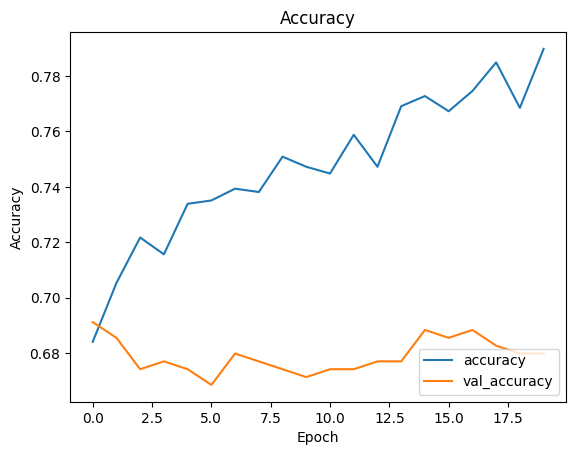

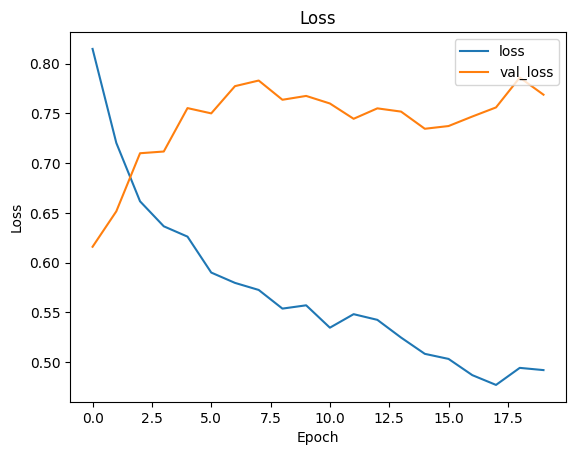

1/1 [==============================] - 2s 2s/step


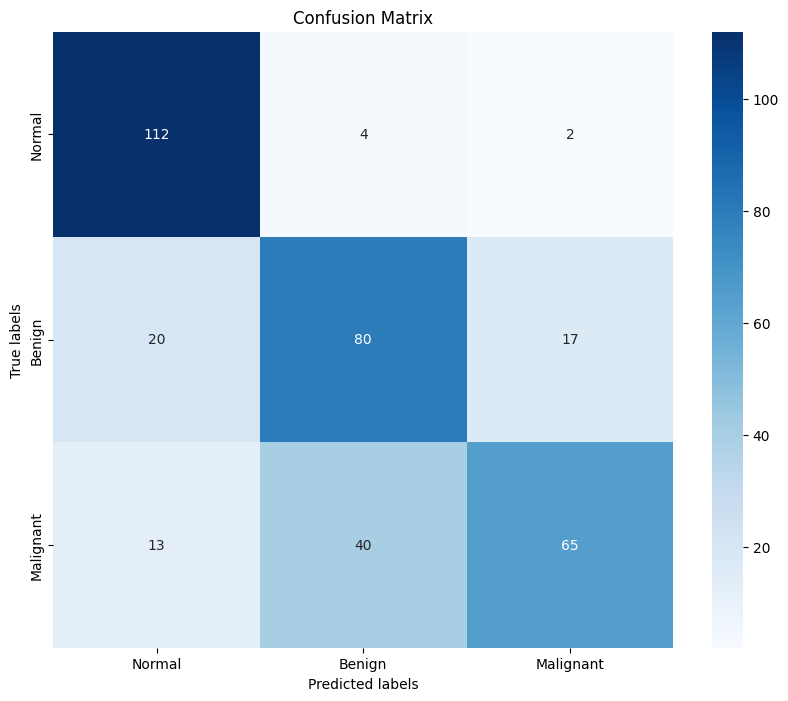

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       118
           1       0.65      0.68      0.66       117
           2       0.77      0.55      0.64       118

    accuracy                           0.73       353
   macro avg       0.73      0.73      0.72       353
weighted avg       0.73      0.73      0.72       353

12/12 [==============================] - 1s 77ms/step - loss: 0.6703 - accuracy: 0.7280
Pèrdua en el conjunt de dades de test: 0.6702808737754822
Precisió en el conjunt de dades de test: 0.7280453443527222


In [42]:
custom_model3.full_report(model=model_retrained_effic2, history=history11)

## 3.6. Descongelem tot el model

In [43]:
model_retrained_effic3 = custom_model3.freeze_layers(model_initial=model_effic, num_layers_to_freeze = 1)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)

history12 = custom_model3.train(model=model_retrained_effic3, optimizer=optimizer, epochs = 20)

custom_model3.show_layers(model_retrained_effic3.layers[2])

Epoch 1/20
52/52 [==============================] - 38s 448ms/step - loss: 0.7258 - accuracy: 0.6731 - val_loss: 0.6905 - val_accuracy: 0.6884
Epoch 2/20
52/52 [==============================] - 21s 409ms/step - loss: 0.6263 - accuracy: 0.7151 - val_loss: 0.6895 - val_accuracy: 0.7082
Epoch 3/20
52/52 [==============================] - 21s 407ms/step - loss: 0.6217 - accuracy: 0.7272 - val_loss: 0.6719 - val_accuracy: 0.7167
Epoch 4/20
52/52 [==============================] - 21s 405ms/step - loss: 0.6006 - accuracy: 0.7151 - val_loss: 0.6945 - val_accuracy: 0.6912
Epoch 5/20
52/52 [==============================] - 21s 405ms/step - loss: 0.5968 - accuracy: 0.7272 - val_loss: 0.6915 - val_accuracy: 0.6912
Epoch 6/20
52/52 [==============================] - 21s 408ms/step - loss: 0.5776 - accuracy: 0.7327 - val_loss: 0.6953 - val_accuracy: 0.6799
Epoch 7/20
52/52 [==============================] - 21s 406ms/step - loss: 0.5860 - accuracy: 0.7169 - val_loss: 0.6744 - val_accuracy: 0.6912

### Avaluem els resultats

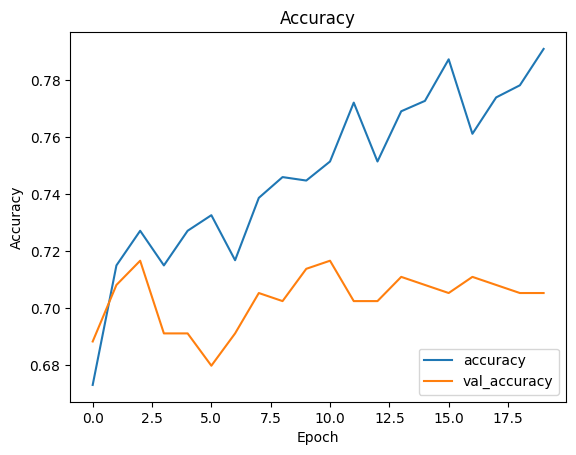

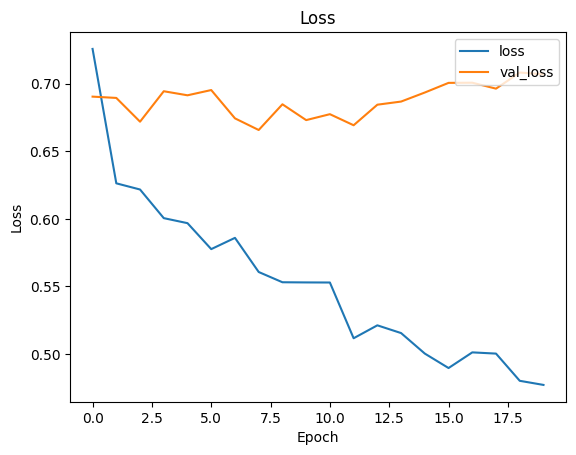

1/1 [==============================] - 2s 2s/step


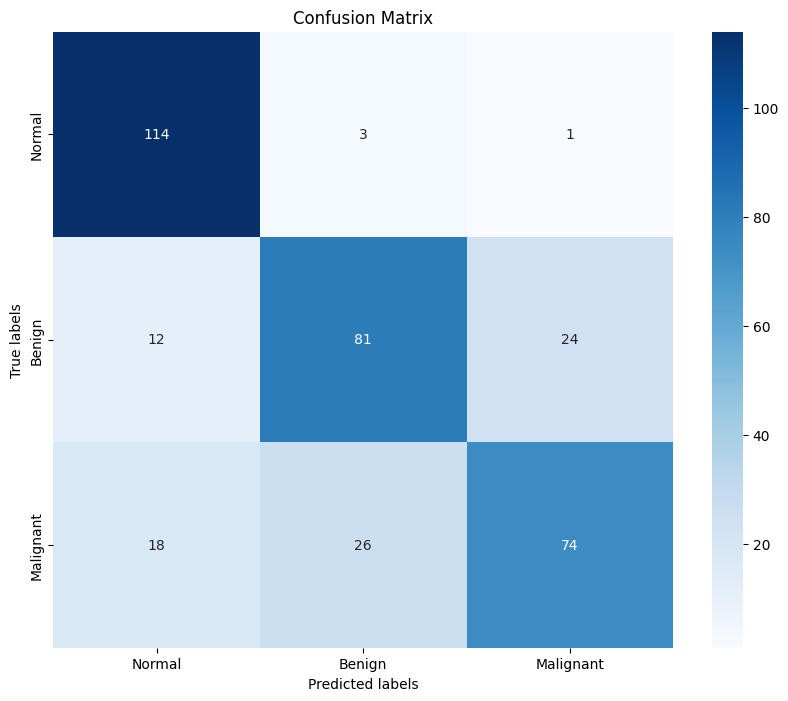

              precision    recall  f1-score   support

           0       0.79      0.97      0.87       118
           1       0.74      0.69      0.71       117
           2       0.75      0.63      0.68       118

    accuracy                           0.76       353
   macro avg       0.76      0.76      0.76       353
weighted avg       0.76      0.76      0.76       353

12/12 [==============================] - 1s 78ms/step - loss: 0.6014 - accuracy: 0.7620
Pèrdua en el conjunt de dades de test: 0.6014204621315002
Precisió en el conjunt de dades de test: 0.7620396614074707


In [44]:
custom_model3.full_report(model=model_retrained_effic3, history=history12)